In [81]:
import pandas as pd
import statistics
import math
from datetime import timedelta
import matplotlib.pyplot as plt
import timeit

2020-10-19 17:40:46.306441 - user 9201 - retry 0 - time 0.07220077514648438 
        - returncode 0 
        - command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x555e443cfe90.3058472/bl_129ykn']

In [2]:
with open('../data/slurm_wrapper_ce5.log') as f:
    data = ([line.split() for line in f if 'sbatch' in line and 'user 9204' in line])
with open('../data/slurm_wrapper_ce6.log') as f:
    data.extend([line.split() for line in f if 'sbatch' in line and 'user 9204' in line])

In [87]:
sbatch = pd.DataFrame([[pd.to_datetime(x[0] + 'T' + x[1]), float(x[10]), int(x[13])] 
                       for x in data], columns=['BEGIN', 'DURATION', 'RETURNCODE'])

In [43]:
sbatch['RETURNCODE'].value_counts()

0    57951
1     3296
Name: RETURNCODE, dtype: int64

In [48]:
# Check the duration of the process which ran before the one that timed out to see if we can
#  use this to flag the load if it is getting to be too much 
before = []
for index, row in sbatch.iterrows():
    if index and row['RETURNCODE'] == 1:
        before.append(sbatch.iloc[index - 1]['DURATION'])
print(statistics.mean(before))
print(statistics.stdev(before))
print(statistics.median(before))

9.843361352470893
9.731232890541792
7.185113787651062


{'whiskers': [<matplotlib.lines.Line2D at 0x25d0b832e80>,
 'caps': [<matplotlib.lines.Line2D at 0x25d0e679b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x25d0b832a30>],
 'medians': [<matplotlib.lines.Line2D at 0x25d0e6793a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25d0e6880a0>],
 'means': []}

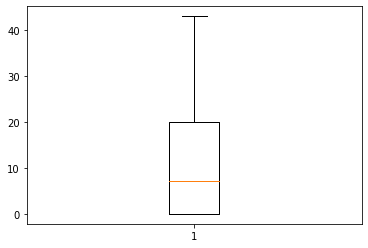

In [52]:
plt.boxplot(before)

In [45]:
count = 0
for index, row in sbatch.iterrows():
    if index and row['RETURNCODE'] == 1 and sbatch.iloc[index - 1]['RETURNCODE'] == 0:
        count += 1
print(count)

2098


In [26]:
sbatch.describe()

,DURATION,RETURNCODE
count,61247.000000,61247.000000
mean,2.066355,0.053815
std,5.271746,0.225654
min,0.018579,0.000000
25%,0.045495,0.000000
50%,0.076634,0.000000
75%,0.306675,0.000000
max,56.397141,1.000000


In [85]:
dur = [math.modf(x) for x in sbatch['DURATION']]

In [ ]:
next(zip(*test[:10]))

In [86]:
td_input = [[x[1], x[0] * 1000000] for x in dur]
dur_td = [timedelta(seconds=x[0], microseconds=x[1]) for x in td_input]

In [90]:
sbatch['END'] = sbatch['BEGIN'].add(dur_td)

In [92]:
begin_load_df = sbatch[['BEGIN']].rename(columns={'BEGIN':'TIME'})
begin_load_df['process'] = 1
end_load_df = sbatch[['END']].rename(columns={'END':'TIME'})
end_load_df['process'] = -1
load_df = begin_load_df.append(end_load_df)

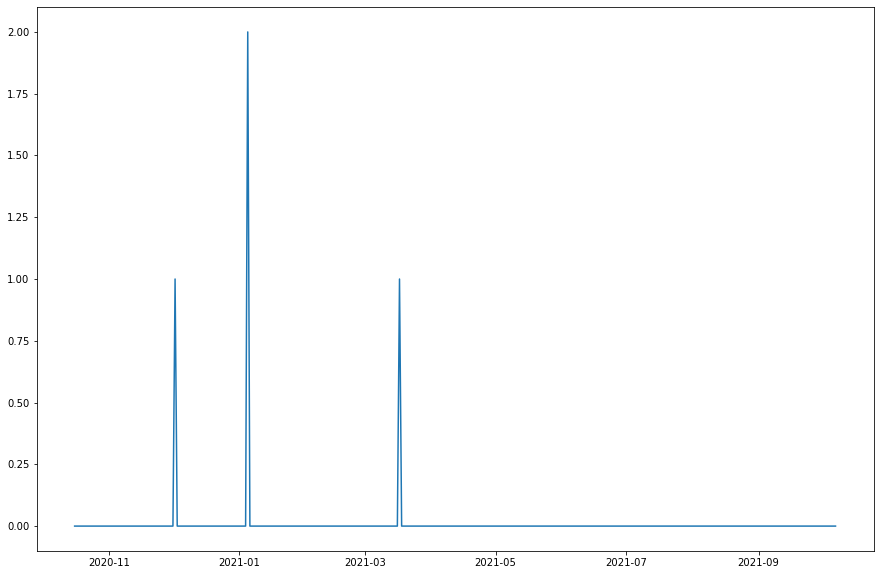

In [93]:
# This doesn't work because day is way too long of a resampling period
resample_interval = "D"
fs_ts = pd.Series(list(load_df['process']), index=list(load_df['TIME']))
fs_resample = fs_ts.resample(resample_interval).sum().to_frame().cumsum()

plt.figure(figsize=(15, 10))
plt.plot(fs_resample.index, fs_resample[0])

In [95]:
fs_resample

,0
2020-10-16,0
2020-10-17,0
2020-10-18,0
2020-10-19,0
2020-10-20,0
...,...
2021-10-03,0
2021-10-04,0
2021-10-05,0
2021-10-06,0
